# Linear Modeling in Python

This notebook walks through an example linear regression model in Python. 

## Import and Explore Data

First, we need some data. In this example we will use the 2017 World Happiness Rankings, which can be found [here](https://promotable2.teachable.com/courses/429444/lectures/6561182). If you do not already have these data downloaded, please do that now, and note the directory on your computer to which you downloaded. Once you have this file downloaded, please run the following cell to import the necessary modules for this exercise.


In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import datasets, linear_model
#from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt

Now, assign to a new object names `path` the location of the CSV file you downloaded. Then use `os.getcwd` to print the newly assigned working directory.

In [2]:
path = "/Users/scottadams/Google_Drive/Promotable/Nov18/day9/"  
os.chdir(path)  
os.getcwd()

'/Users/scottadams/Google_Drive/Promotable/Nov18/day9'

Read the **datasci_day3_world_happiness_rank_2017.csv** file into a new object. Check the first 10 rows.

In [5]:
happy = pd.read_csv("datasci_day3_world_happiness_rank_2017.csv", header = 0)
happy.head(5)

,country,happiness_rank,happiness_score,whisker_high,whisker_low,gdp_per_capita,family,life_epxectancy,freedom,generosity,government_trust,dystopia_residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


Let's get a higher-level overview of our data.

In [7]:
happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
country              155 non-null object
happiness_rank       155 non-null int64
happiness_score      155 non-null float64
whisker_high         155 non-null float64
whisker_low          155 non-null float64
gdp_per_capita       155 non-null float64
family               155 non-null float64
life_epxectancy      155 non-null float64
freedom              155 non-null float64
generosity           155 non-null float64
government_trust     155 non-null float64
dystopia_residual    155 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 14.6+ KB


What country is ranked #1 for happiness?

In [6]:
happy.loc[happy['happiness_rank'] == 1, ['country'] ]

,country
0,Norway


Check for missing data.

In [8]:
happy.isnull().values.any()

False

### _Examining Correlations_

Let's look at the correlations among our outcome, **happiness_score**, and several potential predictors. Remember that correlation is a measure of the strength of the association between two variables and ranges from -1 to +1, where -1 indicates a perfect negative correlation (i.e., as the values in one variable increase the values in the other variable always decrease), 0 indicates no correlation, and +1 means a perfect positive correlation. Here is what these extreme correlation values look like visually. 

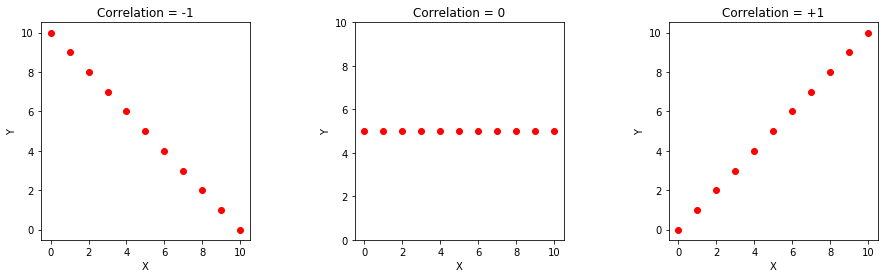

In [130]:
import matplotlib.gridspec as gridspec
%matplotlib inline
gs = gridspec.GridSpec(1, 3)

z1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
z2 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
z3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
z4 = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

f = plt.figure(figsize = (15,4))
ax1 = f.add_subplot(gs[0, 0])
ax2 = f.add_subplot(gs[0, 1])
ax3 = f.add_subplot(gs[0, 2])
f.subplots_adjust(wspace=0.5)


ax1.scatter(z1, z2, color='r')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title("Correlation = -1")

ax2.scatter(z1, z4, color='r')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title("Correlation = 0")
ax2.set_ylim([0,10])

ax3.scatter(z1, z3, color='r')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title("Correlation = +1")

plt.show()

Now let's look at the actual correlations between some candidate variables.

In [32]:
happy.loc[:, ['happiness_score',  'gdp_per_capita', 'freedom', 'government_trust', 'dystopia_residual']].corr()

,happiness_score,gdp_per_capita,freedom,government_trust,dystopia_residual
happiness_score,1.000000,0.812469,0.570137,0.429080,0.475355
gdp_per_capita,0.812469,1.000000,0.369873,0.350944,0.024226
freedom,0.570137,0.369873,1.000000,0.499183,0.081926
government_trust,0.429080,0.350944,0.499183,1.000000,-0.022755
dystopia_residual,0.475355,0.024226,0.081926,-0.022755,1.000000


The correlation between Happiness and GDP is particularly strong at 0.81. This is not too surprising given that GDP is one measure of a nation's economic well-being. If we plot the values of Happiness (on the Y axis) and GDP per capita (on the X axis) for each data point, we will see most of the data points moving up and to the right, illustrating a positive linear trend. 

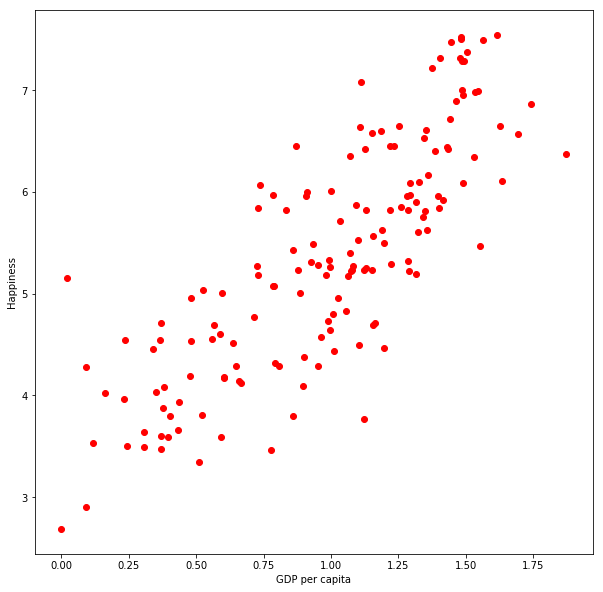

In [146]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.scatter(happy.loc[:, 'gdp_per_capita'], happy.loc[:, 'happiness_score'],color='r')
ax.set_xlabel('GDP per capita')
ax.set_ylabel('Happiness')
plt.show()

Next, we will estimate a simple linear regression model treating GDP per capita as a predictor of Happiness score. 

## Linear Regression with Statsmodel

One way to run linear regression is to use the Statsmodel API. The output from Statsmodel is fairly robust, providing a number of metrics by default that are useful for regression diagnostics.

In [10]:
import statsmodels.api as sm
X2 = happy.loc[:, ['gdp_per_capita']]
X2 = sm.add_constant(X2) # intercept is not added by default, be sure to specify it here!
y2 = happy.loc[:, ['happiness_score']]

model = sm.OLS(y2, X2).fit()
predictions = model.predict(X2) # make the predictions by the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        happiness_score   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     297.1
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           1.11e-37
Time:                        09:34:38   Log-Likelihood:                -154.91
No. Observations:                 155   AIC:                             313.8
Df Residuals:                     153   BIC:                             319.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.2032      0.136     23.619      0.000       2.935       3.471
gdp_per_capita     2.1842      0.127     17.238      0.000       1.934       2.435
==============================================================================
Omnibus:                        0.351   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.494
Skew:                           0.088   Prob(JB):                        0.781
Kurtosis:                       2.787   Cond. No.                         4.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, what does this tell us? Under **coef**, we see that **gdp_per_capita** has a value of 2.1842. This means that a one-unit increase in gdp_per_capita is associated with a 2.1842 unit increase in the happiness score. The value of 0.000 under **P>|t|** tells us that this result is statistically significant. The R-square value for this model is 0.660, which means that our model is accounting for 66% of the variance in happiness. Not bad!

## Linear Regression with Scikit-Learn

Scikit-Learn is a popular Python machine learning library. One of the big differences between linear regression in Scikit-Learn and linear regression Statsmodel is that the user must specify what output they want to see from the Scikit-Learn regression model. 

Before running the regression model with Scikit-Learn, we need to prepare data by placing our target (i.e., our dependent variable/outcome) and features (i.e., independent variables/predictors) into their own arrays, which can be accomplished with the `c_` function in Numpy.

In [11]:
X = np.c_[happy.loc[:, ['gdp_per_capita']]]
y = np.c_[happy.loc[:, 'happiness_score']]

#Look at the first 2 elements
X[0:2]

array([[1.61646318],
       [1.48238301]])

Now we select the linear regression model and assign it to an object. We can also see all the parameters that are defined by default.

In [12]:
lm = linear_model.LinearRegression()
lm.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

Next, train the linear regression model

In [13]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Output relevant metricts including yhat (predicted outcome), residuals and standardized residuals, r-square, and the mean squared error.

In [14]:
yhat = lm.predict(X)
residual = y - yhat
sresidual = residual/residual.std()
r2 = lm.score(X, y) 
mse = metrics.mean_squared_error(y, lm.predict(X))

In [15]:
print(
" MODEL OUTPUT \n",
" \n",  
"====================================\n", 
"Coefficient(s): {} \n" .format(lm.coef_), "Intercept: {} \n" .format(lm.intercept_), "R-Squared: {} \n" .format(r2), "MSE: {} \n" .format(mse),
"====================================\n" 
)

 MODEL OUTPUT 
  
 Coefficient(s): [[2.18418495]] 
 Intercept: [3.20321268] 
 R-Squared: 0.6601054760877703 
 MSE: 0.43215056726384016 



Just like the Statsmodel output, the `Coefficient(s): [[2.18418495]] ` tells us that, on average, a one-unit increase in GDP per capita is associated with a 2.18 unit increase in the Happiness score. The output of `Intercept: [3.20321268]` tells us that when GDP per capita is set to 0 in the model we just ran, the expect Happiness score is 3.20. So, if we rerun the scatter plot between GDP per capita and Happiness Score our line of best fit will start at 3.20 and with every 1-unit increase in GDP per capita the predicted value of y (also called y-hat or $\hat{y}$) will increase by a value of 2.18. 

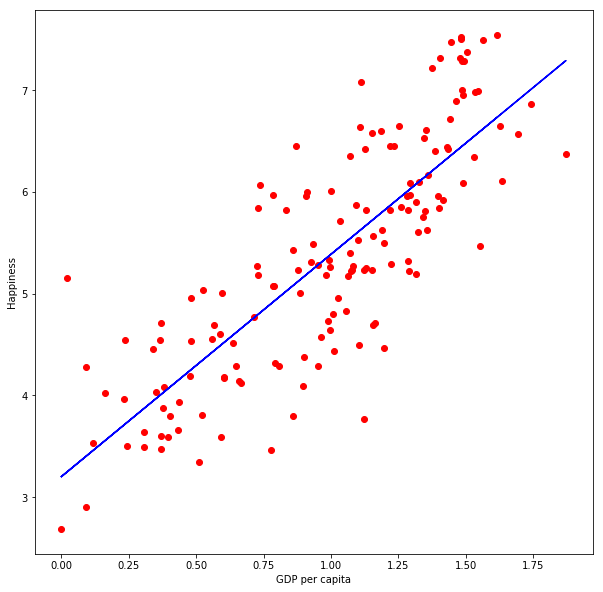

In [145]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.scatter(X, y,color='r')
ax.plot(X, lm.predict(X),color='blue')
ax.set_xlabel('GDP per capita')
ax.set_ylabel('Happiness')
plt.show()

Let's think a little more about what is going on here. As stated above, our line of best fit starts 3.20 and with every 1-unit increase in GDP per capita the predicted value of y increases by a value of 2.18. To better illustrate this, let's draw a dashed vertical line at GDP Per Capital = 1, which can be plotted with the code `plt.axvline(1, color='k', linestyle='dashed', linewidth=1)`.

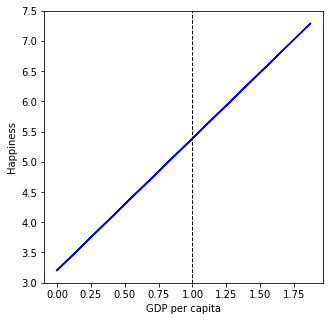

In [137]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(X, lm.predict(X),color='blue')
ax.set_xlabel('GDP per capita')
ax.set_ylabel('Happiness')
plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
plt.show()

Now let's put a horizontal line at the predicted Happiness Score when GDP Per Capita = 1, which can be plotted with the code `plt.axhline((lm.coef_ * 1) + lm.intercept_, color='k', linestyle='dashed', linewidth=1)`. 

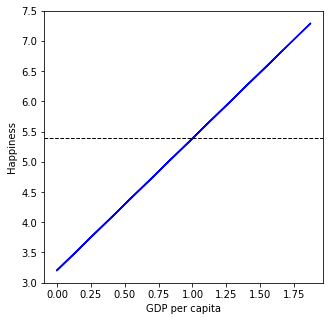

In [144]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(X, lm.predict(X),color='blue')
ax.set_xlabel('GDP per capita')
ax.set_ylabel('Happiness')
#plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
#Show intersection between GDP per capital =1 and the associated predicted Happiness Score value
plt.axhline((lm.coef_ * 1) + lm.intercept_, color='k', linestyle='dashed', linewidth=1)
plt.show()

Lastly, let's plot both the dashed horizontal and vertical lines over our line of best fit. The point where the the dashed horizontal and vertical line meet will fall right on the line of best fit, pinpointing the predicted value of Happiness when GPD per Capital equals 1.

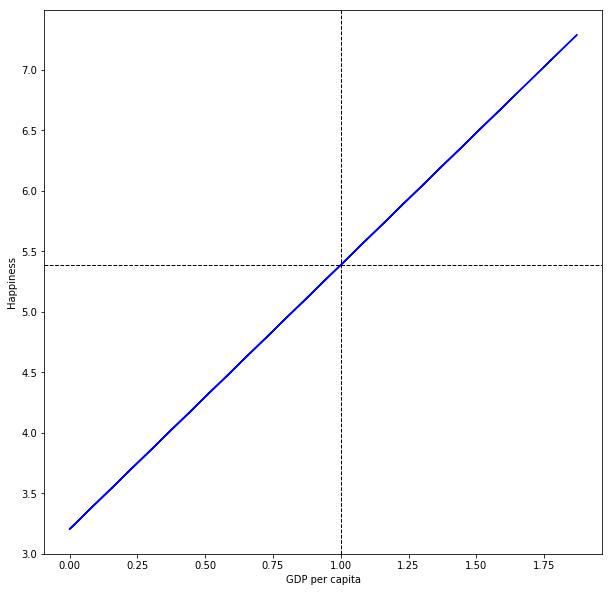

In [142]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.plot(X, lm.predict(X),color='blue')
ax.set_xlabel('GDP per capita')
ax.set_ylabel('Happiness')
plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
#Show intersection between GDP per capital =1 and the associated predicted Happiness Score value
plt.axhline((lm.coef_ * 1) + lm.intercept_, color='k', linestyle='dashed', linewidth=1)
plt.show()

And about the r-square value. You will notice that in a regression model with a single predictor, it is just the squared correlation between the predictor and outcome.

In [16]:
happy['happiness_score'].corr(happy["gdp_per_capita"])**2, r2

(0.6601054760877708, 0.6601054760877703)

Let's check the standardized residuals.

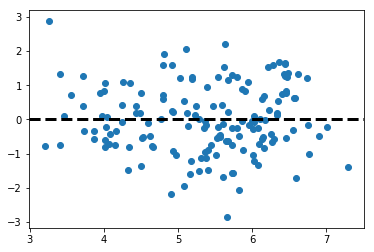

In [17]:
plt.scatter(yhat, sresidual)
plt.axhline(0, color='k', linestyle='dashed', linewidth=3)
plt.show()

Are the residuals normally distributed?

/Users/scottadams/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


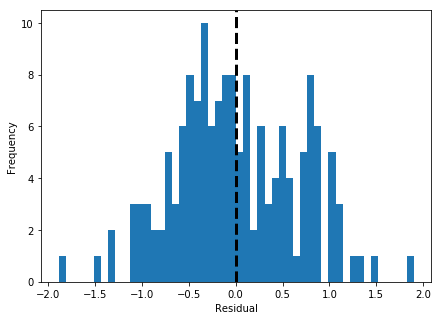

In [18]:
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
ax.hist(residual, bins=50)
plt.axvline(residual.mean(), color='k', linestyle='dashed', linewidth=3)
ax.set_xlabel('Residual')
ax.set_ylabel('Frequency')
f.show()

Finally, let's take a look at our line of best fit.

We may be able to improve our model with additional predictors.

In [20]:
Xm2 = np.c_[happy.loc[:, ['gdp_per_capita', 'freedom']]]
lm2 = linear_model.LinearRegression()
lm2.fit(Xm2, y)
yhat2 = lm2.predict(Xm2)
residual2 = y - yhat2
sresidual2 = residual2/residual2.std()
r2_m2 = lm2.score(Xm2, y) 
mse2 = metrics.mean_squared_error(y, lm2.predict(Xm2))

print(
" MODEL OUTPUT \n",
" \n",  
"====================================\n", 
"Coefficient(s): {} \n" .format(lm2.coef_), "Intercept: {} \n" .format(lm2.intercept_), "R-Squared: {} \n" .format(r2_m2), "MSE: {} \n" .format(mse2),
"====================================\n" 
)

 MODEL OUTPUT 
  
 Coefficient(s): [[1.87359289 2.35571106]] 
 Intercept: [2.5460767] 
 R-Squared: 0.7443258733192046 
 MSE: 0.3250706060457865 



In the output, `Coefficient(s): [[1.87359289 2.35571106]]`, the first coefficient of 1.87 (rounded) is the slope for GDP per capita, and the second coefficient is the slope for Freedom. 

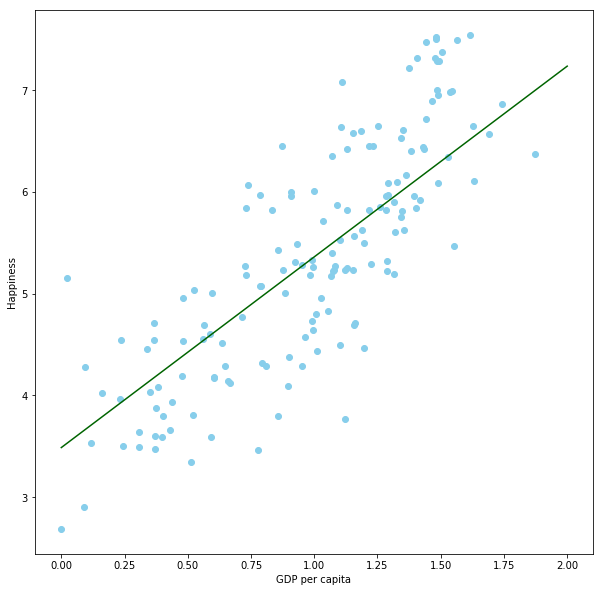

In [22]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.scatter(Xm2[:, 0], y,color='skyblue')
ax.plot([0, 0.5, 1, 1.5,  2], lm2.predict([[0, 0.4], [0.5, 0.4], [1, 0.4], [1.5, 0.4], [2, 0.4]]),color='darkgreen')
ax.set_xlabel('GDP per capita')
ax.set_ylabel('Happiness')
plt.show()

Let's compare the line of best fit for GDP per capita from our original model, in blue, to GDP per capita net of Freedom, in green.

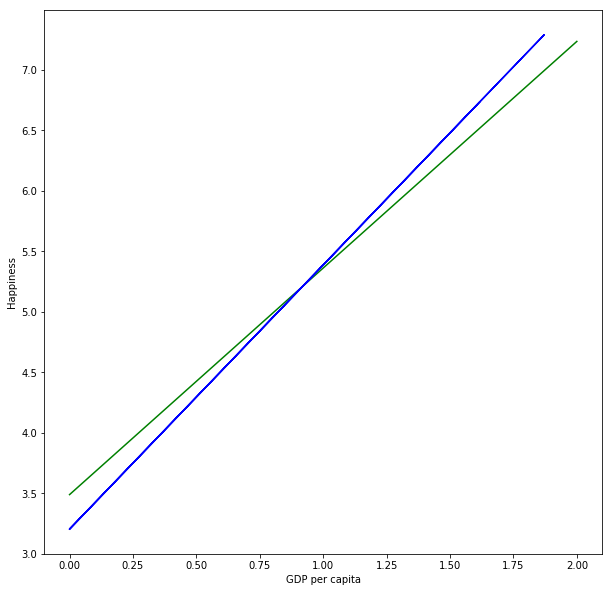

In [23]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.plot([0, 0.5, 1, 1.5,  2], lm2.predict([[0, 0.4], [0.5, 0.4], [1, 0.4], [1.5, 0.4], [2, 0.4]]),color='g')
ax.plot(X, lm.predict(X),color='b')
ax.set_xlabel('GDP per capita')
ax.set_ylabel('Happiness')
plt.show()
